# facial-emotion-detection-and-classification

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
import cv2
import pywt
import os
import pickle
import random

### Let's visualize some image

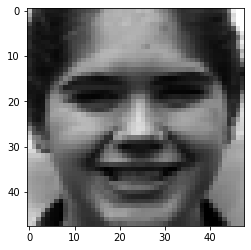

In [3]:
test_img = cv2.imread('CK+48/happy/S011_006_00000011.png')
plt.imshow(test_img)
plt.show()

In [4]:
test_img.shape

(48, 48, 3)

### Taking all the images from the image dataset

In [5]:
path_to_data = 'CK+48'
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [6]:
img_dirs

['CK+48/angry',
 'CK+48/fear',
 'CK+48/neutral',
 'CK+48/surprise',
 'CK+48/happy',
 'CK+48/sad',
 'CK+48/disgust']

In [7]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [8]:
emotions

['angry', 'fear', 'neutral', 'surprise', 'happy', 'sad', 'disgust']

In [9]:
data = []
for emotion in emotions:
    path = os.path.join(path_to_data, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        emotion_img = cv2.imread(imgpath, 0)
        try:
            emotion_img = cv2.resize(emotion_img, (48, 48))
            image = np.array(emotion_img).flatten()
        
            data.append([image, label])
        except Exception as e:
            pass

angry --> 0
fear --> 1
neutral --> 2
surprise --> 3
happy --> 4
sad --> 5
disgust --> 6


In [10]:
print(len(data))

1400


### Splitting the data into features and labels where X --> features & y --> labels

In [11]:
# random.shuffle(data)
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)

### Now let's do some feature scaling

In [12]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X = ss.fit_transform(X)

### Splitting the data into training and test set

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fitting the model into train set

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=100, gamma='auto')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7321428571428571

In [15]:
SVC(kernel='linear', C=100, gamma='auto').fit(X_train, y_train).score(X_test, y_test)

0.7357142857142858

In [16]:
SVC(kernel='poly', C=100, gamma='auto').fit(X_train, y_train).score(X_test, y_test)

0.7178571428571429

### K-fold Cross validation

In [17]:
kernels = ['linear', 'rbf', 'poly']
C = [1, 10, 20, 50, 100]
avg_scores = {}
for kernel in kernels:
    for cval in C:
        cv_scores = cross_val_score(SVC(kernel=kernel, C=cval, gamma='auto'), X, y, cv=5)
        avg_scores[kernel+"_"+str(cval)] = np.average(cv_scores)

avg_scores

{'linear_1': 0.7192857142857143,
 'linear_10': 0.7192857142857143,
 'linear_20': 0.7192857142857143,
 'linear_50': 0.7192857142857143,
 'linear_100': 0.7192857142857143,
 'rbf_1': 0.687857142857143,
 'rbf_10': 0.7292857142857143,
 'rbf_20': 0.7292857142857143,
 'rbf_50': 0.7292857142857143,
 'rbf_100': 0.7292857142857143,
 'poly_1': 0.5928571428571429,
 'poly_10': 0.7114285714285714,
 'poly_20': 0.72,
 'poly_50': 0.7207142857142858,
 'poly_100': 0.7128571428571429}

### Grid Search CV

In [18]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [19]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [20]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.716071,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.647321,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.704464,{'logisticregression__C': 1}


In [21]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [22]:
best_estimators['svm'].score(X_test,y_test)

0.7321428571428571

In [23]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.725

In [24]:
best_estimators['random_forest'].score(X_test,y_test)

0.6857142857142857

In [25]:
best_clf = best_estimators['svm']

In [26]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[36,  2,  4,  0,  0,  1,  0],
       [ 1, 21, 10,  0,  0,  7,  1],
       [ 4, 13, 23,  0,  0,  8,  1],
       [ 0,  0,  0, 30,  0,  1,  0],
       [ 0,  0,  0,  0, 41,  0,  0],
       [ 2,  3,  9,  0,  0, 17,  1],
       [ 1,  1,  3,  0,  0,  2, 37]])

Text(69.0, 0.5, 'Truth')

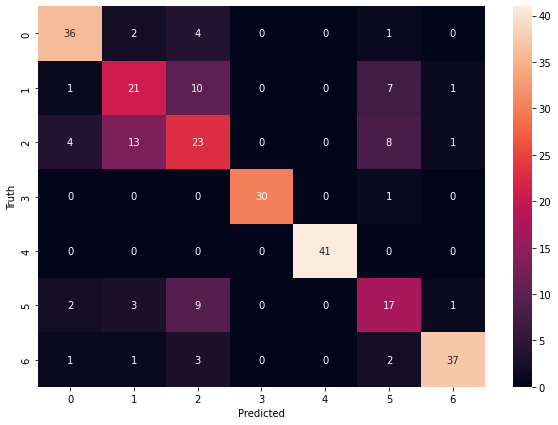

In [28]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

- angry --> 0
- fear --> 1
- neutral --> 2
- surprise --> 3
- happy --> 4
- sad --> 5
- disgust --> 6